In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

# Loading Data

In [3]:
data = pd.read_csv('..\..\datasets\A_Flood_Dataset.csv')
data.head()

,Sl,Station_Names,Year,Month,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,LATITUDE,LONGITUDE,ALT,Period,Flood?
0,0,Barisal,1949,1,29.4,12.3,0.0,68.0,0.453704,0.6,7.831915,41950,536809.8,510151.9,22.7,90.36,4,1949.01,NaN
1,1,Barisal,1949,2,33.9,15.2,9.0,63.0,0.659259,0.9,8.314894,41950,536809.8,510151.9,22.7,90.36,4,1949.02,NaN
2,2,Barisal,1949,3,36.7,20.2,8.0,59.0,1.085185,1.5,8.131915,41950,536809.8,510151.9,22.7,90.36,4,1949.03,NaN
3,3,Barisal,1949,4,33.9,23.9,140.0,71.0,1.772222,3.9,8.219149,41950,536809.8,510151.9,22.7,90.36,4,1949.04,NaN
4,4,Barisal,1949,5,35.6,25.0,217.0,76.0,1.703704,4.1,7.046809,41950,536809.8,510151.9,22.7,90.36,4,1949.05,NaN


In [4]:
df = data.drop(columns=['Sl', 'Station_Names', 'Station_Number', 'X_COR', 'Y_COR', 'Period'])
df = df.drop(columns=['LATITUDE', 'LONGITUDE'])
df['Flood?'] = df['Flood?'].fillna(0).astype(int)
df.sort_values(by=['Year','Month'], inplace=True)

In [5]:
print("df shape :", df.shape, "\n")
df.info()
# df.describe()

df shape : (20544, 11) 

<class 'pandas.core.frame.DataFrame'>
Index: 20544 entries, 1356 to 20543
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               20544 non-null  int64  
 1   Month              20544 non-null  int64  
 2   Max_Temp           20544 non-null  float64
 3   Min_Temp           20544 non-null  float64
 4   Rainfall           20544 non-null  float64
 5   Relative_Humidity  20544 non-null  float64
 6   Wind_Speed         20544 non-null  float64
 7   Cloud_Coverage     20544 non-null  float64
 8   Bright_Sunshine    20544 non-null  float64
 9   ALT                20544 non-null  int64  
 10  Flood?             20544 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 1.9 MB


# Data Splitting & Window Sliding

In [6]:
X = df.drop(columns=['Year', 'Flood?'])
Y = df['Flood?']

In [7]:
""" SLIDING WINDOW """
WINDOW_SIZE = 5
def create_dataset(X, Y):
    Xs, ys = [], []
    for i in range(len(X) - WINDOW_SIZE):
        v = X[i:(i + WINDOW_SIZE)]
        Xs.append(v)
        ys.append(Y.iloc[i + WINDOW_SIZE])
    return np.array(Xs), np.array(ys)

X_seq, Y_seq = create_dataset(X, Y)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, Y_seq, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [9]:
from sklearn.preprocessing import MinMaxScaler

# --- Reshape for scaling ---
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# --- Initialize and fit scaler ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)

# --- Transform validation and test data ---
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# --- Reshape back to original 3D shape ---
X_train_seq = X_train_scaled.reshape(X_train.shape)
X_val_seq = X_val_scaled.reshape(X_val.shape)
X_test_seq = X_test_scaled.reshape(X_test.shape)

In [10]:
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau

def build_lstm_model(learning_rate=0.0001):
  model = Sequential()
  model.add(Input(shape=(WINDOW_SIZE, X.shape[1])))
  model.add(LSTM(64, return_sequences=True))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(LSTM(32, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(LSTM(16, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)
  loss = BinaryCrossentropy()
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

  return model

model = build_lstm_model()
lr_scheduler = ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.5,
  patience=5,
  min_lr=1e-5,
  verbose=1
)
model.input_shape

(None, 5, 9)

In [11]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

tf.random.set_seed(42)
history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5983 - loss: 0.6587 - val_accuracy: 0.7780 - val_loss: 0.5272 - learning_rate: 1.0000e-04
Epoch 2/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8261 - loss: 0.4429 - val_accuracy: 0.8558 - val_loss: 0.3364 - learning_rate: 1.0000e-04
Epoch 3/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8433 - loss: 0.3490 - val_accuracy: 0.8571 - val_loss: 0.3113 - learning_rate: 1.0000e-04
Epoch 4/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8405 - loss: 0.3227 - val_accuracy: 0.8571 - val_loss: 0.3090 - learning_rate: 1.0000e-04
Epoch 5/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8499 - loss: 0.3083 - val_accuracy: 0.8522 - val_loss: 0.3073 - learning_rate: 1.0000e-04
Epoch 6/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8440 - loss: 0.3038 - val_accuracy: 0.8601 - val_loss: 0.3056 - learning_rate: 1.0000e-04
Epoch 7/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - ac

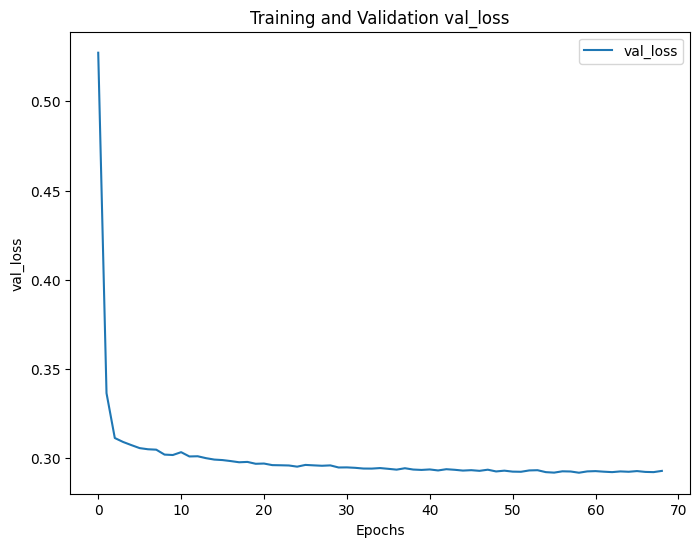

In [12]:
def plot_history(history, key):
  plt.figure()
  plt.plot(history.history[key], label=key)
  plt.xlabel('Epochs')
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.title(f"Training and Validation {key}")
  plt.show()

plot_history(history, 'val_loss')

In [13]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_seq)
y_pred = (y_pred >= 0.5).astype(int)

print("Accuracy : ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy :  0.8439629990262901
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      3206
           1       0.67      0.58      0.62       902

    accuracy                           0.84      4108
   macro avg       0.78      0.75      0.76      4108
weighted avg       0.84      0.84      0.84      4108



In [14]:
import pandas as pd

# Flatten the arrays before creating Series
y_pred_flat = y_pred.ravel()  # or use y_pred.flatten()
y_test_flat = y_test.ravel()  # or use y_test.flatten()

# Create DataFrames and get value counts in one step
y_pred_counts = pd.Series(y_pred_flat).value_counts().reset_index(name='y_pred_count')
y_test_counts = pd.Series(y_test_flat).value_counts().reset_index(name='y_test_count')

# Rename 'index' to 'Value' for both DataFrames before merging
y_pred_counts.rename(columns={'index': 'Value'}, inplace=True)
y_test_counts.rename(columns={'index': 'Value'}, inplace=True)

# Merge the counts and align them by 'Value'
merged_counts = pd.merge(y_pred_counts, y_test_counts, on='Value', how='outer')

# Display the result
merged_counts.head()


,Value,y_pred_count,y_test_count
0,0,3331,3206
1,1,777,902


In [15]:
import os
os.makedirs('trained_model', exist_ok=True)
model.save(os.path.join('trained_model', 'DL_verA_trained.keras'))

## Cross Validation

In [18]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5) # You can adjust the number of splits

fold_accuracies = []
fold_classification_reports = []
fold = 0
for train_index, test_index in tscv.split(X_seq):
    fold += 1
    print(f"Processing Fold {fold}...")

    # Split data into train and test for this fold
    X_train_fold, X_test_fold = X_seq[train_index], X_seq[test_index]
    y_train_fold, y_test_fold = Y_seq[train_index], Y_seq[test_index]

    # Further split the training fold into train and validation
    # We maintain the time series nature, so no shuffling
    # Split size for validation can be adjusted
    val_size = int(len(X_train_fold) * 0.1)
    X_train_inner, X_val_fold = X_train_fold[:-val_size], X_train_fold[-val_size:]
    y_train_inner, y_val_fold = y_train_fold[:-val_size], y_train_fold[-val_size:]

    # Reshape for scaling
    X_train_inner_reshaped = X_train_inner.reshape(-1, X_train_inner.shape[-1])
    X_val_fold_reshaped = X_val_fold.reshape(-1, X_val_fold.shape[-1])
    X_test_fold_reshaped = X_test_fold.reshape(-1, X_test_fold.shape[-1])

    # Initialize and fit scaler on the training data of this fold
    scaler_fold = MinMaxScaler()
    X_train_inner_scaled = scaler_fold.fit_transform(X_train_inner_reshaped)

    # Transform validation and test data using the scaler fitted on the training data
    X_val_fold_scaled = scaler_fold.transform(X_val_fold_reshaped)
    X_test_fold_scaled = scaler_fold.transform(X_test_fold_reshaped)

    # Reshape back to original 3D shape
    X_train_inner_seq = X_train_inner_scaled.reshape(X_train_inner.shape)
    X_val_fold_seq = X_val_fold_scaled.reshape(X_val_fold.shape)
    X_test_fold_seq = X_test_fold_scaled.reshape(X_test_fold.shape)


    # Build and compile a fresh model for each fold
    model_fold = build_lstm_model()

    # Define callbacks
    lr_scheduler_fold = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-5,
        verbose=0 # Set verbose to 0 for cleaner output
    )
    early_stopping_fold = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train the model
    history_fold = model_fold.fit(
        X_train_inner_seq, y_train_inner,
        validation_data=(X_val_fold_seq, y_val_fold),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping_fold, lr_scheduler_fold],
        verbose=0 # Set verbose to 0 for cleaner output
    )

    # Evaluate the model on the test set of this fold
    y_pred_fold = model_fold.predict(X_test_fold_seq)
    y_pred_fold = (y_pred_fold >= 0.5).astype(int)

    # Store accuracy & classification Report
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    fold_accuracies.append(accuracy)
    report_dict = classification_report(y_test_fold, y_pred_fold, output_dict=True)
    fold_classification_reports.append(report_dict)

    # Print evaluation metrics for the fold
    print(f"--- Fold {fold} Results ---")
    print("Accuracy : ", accuracy)
    print("Classification Report:\n", classification_report(y_test_fold, y_pred_fold))
    print("-" * 20)

Processing Fold 1...
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
--- Fold 1 Results ---
Accuracy :  0.8326029798422436
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      2757
           1       0.59      0.44      0.51       666

    accuracy                           0.83      3423
   macro avg       0.73      0.68      0.70      3423
weighted avg       0.82      0.83      0.82      3423

--------------------
Processing Fold 2...
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
--- Fold 2 Results ---
Accuracy :  0.8290972830850132
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90      2764
           1       0.56      0.50      0.53       659

    accuracy                           0.83      3423
   macro avg       0.72      0.70      0.71      3423
weighted avg       0.82      0.83      0.83      3423

--------------------
Processing Fold 3...
10

In [19]:
print("\n--- Cross-Validation Summary ---")
print(f"Average Accuracy  : {np.mean(fold_accuracies):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies):.4f}")

# Convert each report dict into a DataFrame
reports_dfs = [pd.DataFrame(report).transpose() for report in fold_classification_reports]
# Concatenate all DataFrames into one with a MultiIndex (fold index, class label)
all_reports_df = pd.concat(reports_dfs, keys=range(len(reports_dfs)), axis=0)
# Group by class label (level=1) and compute mean of metrics
mean_report_df = all_reports_df.groupby(level=1).mean()

print("\nAverage Classification Report:")
print(mean_report_df)


--- Cross-Validation Summary ---
Average Accuracy  : 0.8403
Standard Deviation: 0.0099

Average Classification Report:
              precision    recall  f1-score      support
0              0.891933  0.909957  0.900634  2721.000000
1              0.616891  0.567254  0.588252   702.000000
accuracy       0.840257  0.840257  0.840257     0.840257
macro avg      0.754412  0.738605  0.744443  3423.000000
weighted avg   0.835901  0.840257  0.837067  3423.000000
